In [1]:
import functools

import numpy as np
from collections import defaultdict
from scipy.special import expit

import pyspark.sql.functions as psf
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.functions import udf, pandas_udf
from pyspark.sql.functions import col
import pyspark.sql as pysql
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, MapType, ArrayType, FloatType, BooleanType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
# from operator import add
# from functools import reduce

pd.set_option('display.max_columns', None)
spark.conf.set('spark.sql.session.timeZone', 'UTC')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
4,application_1652211772651_0009,pyspark,idle,Link,Link,gakumar,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
input_cols = ['tx_ucast_packets', 'rxpkt_rank_pct', 'name', 'num_vlan', 'rx_ucast_root_avg', 
              'tx_mcast_packets', 'site_id', 'hour', 'tx_upkt_rank_pct', 'txpkt_rank_pct', 
              'rx_ucast_packets', 'tx_root_avg', 'rx_mcast_packets', 'rx_upkt_rank_avg', 
              'rxpkt_rank_avg', 'rx_packets', 'tx_bcast_packets', 'rx_root_avg', 
              'rx_bcast_packets', 'tx_rx_root_avg', 'tx_ucast_root_avg', 'remotecap', 'rmbps', 
              'events_count', 'tx_upkt_rank_avg', 'tx_packets', 're_ix', 'physical_port_count', 
              'bridge_port_count', 'switch_id', 'txpkt_rank_avg', 'rx_upkt_rank_pct', 'label', 
              'tx_rx_ucast_root_avg', 'bridge']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Reading from local_path 
# local_s3_path = "s3://mist-data-science-dev/gakumar/uplink/training_data/data_6mar/"

ae_local_s3_path = "s3://mist-data-science-dev/gakumar/uplink/training_data/new_ae_data_20apr/*/*"
old_local_s3_path = "s3://mist-data-science-dev/gakumar/uplink/training_data/new_data_31mar_backup/*/*"
extra_old_local_s3_path = "s3://mist-data-science-dev/gakumar/uplink/training_data/new_data_31mar_extra/*/*"


df_train_old = spark.read.parquet(old_local_s3_path).select(input_cols)
df_train_extra = spark.read.parquet(extra_old_local_s3_path).select(input_cols)
df_train = spark.read.parquet(ae_local_s3_path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
df_new = df_train.toPandas()
df_old = df_train_old.toPandas()
df_extra = df_train_extra.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
df_new.shape, df_old.shape, df_extra.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

((199824, 42), (181990, 35), (17829, 35))

In [6]:
df_combined = pd.concat([df_old, df_extra], ignore_index=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df_combined.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(199819, 35)

# Mixing Data

In [8]:
df_agg_port = df_new.groupby(["site_id", "switch_id", "hour"]).agg({"ae_port": "sum"}).reset_index()
df_agg_port.rename(columns = {"ae_port":"ae_port_count"}, inplace=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# df = df_combined.merge(df_new[["site_id", "switch_id", "name", "hour", "ae_port"]], how="left", 
#                        on=["site_id", "switch_id", "name", "hour"])
df = df_new.merge(df_agg_port, how="left", on=["site_id", "switch_id", "hour"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
# Using events count to normalize data
avg_data_cols_list = ['rx_packets', 'tx_packets', 'rx_ucast_packets', 'tx_ucast_packets', 
                        'rx_bcast_packets', 'tx_bcast_packets', 'rx_mcast_packets', 'tx_mcast_packets']
for col in avg_data_cols_list:
    df[col+"_avg"] = df[col]/df["events_count"]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Index(['switch_id', 'name', 'org_id', 'site_id', 'device_type', 're_ix',
       'ae_port', 'events_count', 'remotecap', 'rmbps', 'bridge', 'num_vlan',
       'rx_packets', 'tx_packets', 'rx_bcast_packets', 'tx_bcast_packets',
       'rx_mcast_packets', 'tx_mcast_packets', 'rx_ucast_packets',
       'tx_ucast_packets', 'rxpkt_ranks', 'txpkt_ranks', 'rx_upkt_ranks',
       'tx_upkt_ranks', 'rxpkt_rank_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg',
       'tx_upkt_rank_avg', 'physical_port_count', 'bridge_port_count',
       'rx_root_avg', 'tx_root_avg', 'tx_rx_root_avg', 'rx_ucast_root_avg',
       'tx_ucast_root_avg', 'tx_rx_ucast_root_avg', 'rxpkt_rank_pct',
       'txpkt_rank_pct', 'rx_upkt_rank_pct', 'tx_upkt_rank_pct', 'label',
       'hour', 'ae_port_count', 'rx_packets_avg', 'tx_packets_avg',
       'rx_ucast_packets_avg', 'tx_ucast_packets_avg', 'rx_bcast_packets_avg',
       'tx_bcast_packets_avg', 'rx_mcast_packets_avg', 'tx_mcast_packets_avg'],
      dtype='object')

In [12]:
df.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(199824, 51)

In [13]:
Cont_cols = ['ae_port_count', 'events_count', 'rx_packets_avg', 'tx_packets_avg', 'rx_ucast_packets_avg',
       'tx_ucast_packets_avg', 'physical_port_count', 'bridge_port_count',
       'rx_root_avg', 'tx_root_avg', 'tx_rx_root_avg', 'rx_ucast_root_avg',
       'tx_ucast_root_avg', 'tx_rx_ucast_root_avg', 'rxpkt_rank_avg',
       'txpkt_rank_avg', 'rx_upkt_rank_avg', 'tx_upkt_rank_avg',
       'rxpkt_rank_pct', 'txpkt_rank_pct', 'rx_upkt_rank_pct',
       'tx_upkt_rank_pct', 'rx_mcast_packets_avg', 'tx_mcast_packets_avg',
       'rx_bcast_packets_avg', 'tx_bcast_packets_avg', 'num_vlan']
# Cat_cols = ['remotecap', 'rmbps', 'bridge']
# cat_cols_list = ['remotecap', 'rmbps', 'bridge', 'ae_port']
cat_cols_list = ['remotecap', 'rmbps', 'bridge']

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
remove_cols = [
    'tx_packets_avg', 'rx_root_avg',
    'tx_root_avg',
#     'tx_rx_ucast_root_avg',
#     'txpkt_rank_avg',    # Experimenting removing this
    'events_count', # Experimenting removing this
    'tx_rx_root_avg',
    'rx_ucast_root_avg',
    'tx_ucast_root_avg',
    'rxpkt_rank_pct',
    'rx_upkt_rank_pct',
    'tx_upkt_rank_pct',
    'rxpkt_rank_avg',
    'tx_upkt_rank_avg',
    'txpkt_rank_pct',
    'physical_port_count',
    # Experimenting by removing other variables
    'rx_mcast_packets_avg',
    'rx_ucast_packets_avg',
    'tx_mcast_packets_avg',
    'ae_port_count',
]

print("Continuous Columns: ", len(Cont_cols))
for col in remove_cols:
    Cont_cols.remove(col)
    
print("Continuous Columns after removal: ", len(Cont_cols))
print("Names: ", Cont_cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Continuous Columns:  27
Continuous Columns after removal:  9
Names:  ['rx_packets_avg', 'tx_ucast_packets_avg', 'bridge_port_count', 'tx_rx_ucast_root_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'rx_bcast_packets_avg', 'tx_bcast_packets_avg', 'num_vlan']

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Site based split

In [16]:
site_list = df["site_id"].unique().tolist()
train, test = train_test_split(site_list, test_size=0.3, random_state=111, shuffle=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
len(train), len(test), len(site_list)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(41, 18, 59)

In [18]:
df_train = df[df["site_id"].isin(train)].reset_index(drop=True)
df_train.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(114965, 51)

In [19]:
df_test = df[df["site_id"].isin(test)].reset_index(drop=True)
df_test.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(84859, 51)

In [20]:
df_train["label"].sum(), df_test["label"].sum()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(7900, 3652)

In [21]:
scaling_columns = [f for f in Cont_cols if ("root" not in f) and ("pct" not in f)]

Scaler = StandardScaler()
df_train.loc[:, scaling_columns] = Scaler.fit_transform(df_train.loc[:, scaling_columns])
df_test.loc[:, scaling_columns] = Scaler.transform(df_test.loc[:, scaling_columns])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
print("Missing Set: ", set(Cont_cols) - set(scaling_columns))
print("Extra Set: ", set(scaling_columns) - set(Cont_cols))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Missing Set:  {'tx_rx_ucast_root_avg'}
Extra Set:  set()

In [23]:
scaler_site = defaultdict(list)
mean_list = Scaler.mean_
std_list = Scaler.scale_
for i, col in enumerate(scaling_columns):
    scaler_site[col].append(mean_list[i])
    scaler_site[col].append(std_list[i])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
scaler_site

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

defaultdict(<class 'list'>, {'rx_packets_avg': [694470.594191648, 8195686.776729621], 'tx_ucast_packets_avg': [62694.78502470797, 1033492.8308811807], 'bridge_port_count': [2.137343970429111, 3.0058833464809322], 'txpkt_rank_avg': [21.221940943802682, 22.868277543132905], 'rx_upkt_rank_avg': [27.74682636482497, 30.67872753684398], 'rx_bcast_packets_avg': [6133.404105248202, 60206.29674807401], 'tx_bcast_packets_avg': [29768.912004718633, 94925.90124482622], 'num_vlan': [3.5021441308224244, 8.734175118462634]})

In [25]:
for k, v in scaler_site.items():
    print(k, ":", v)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rx_packets_avg : [694470.594191648, 8195686.776729621]
tx_ucast_packets_avg : [62694.78502470797, 1033492.8308811807]
bridge_port_count : [2.137343970429111, 3.0058833464809322]
txpkt_rank_avg : [21.221940943802682, 22.868277543132905]
rx_upkt_rank_avg : [27.74682636482497, 30.67872753684398]
rx_bcast_packets_avg : [6133.404105248202, 60206.29674807401]
tx_bcast_packets_avg : [29768.912004718633, 94925.90124482622]
num_vlan : [3.5021441308224244, 8.734175118462634]

In [26]:
Cont_cols + cat_cols_list

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['rx_packets_avg', 'tx_ucast_packets_avg', 'bridge_port_count', 'tx_rx_ucast_root_avg', 'txpkt_rank_avg', 'rx_upkt_rank_avg', 'rx_bcast_packets_avg', 'tx_bcast_packets_avg', 'num_vlan', 'remotecap', 'rmbps', 'bridge']

#### RandomForest

In [27]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://mlflow-tracking-staging.mist.pvt/")
experiment_id = mlflow.set_experiment("Uplink_Model_Gk_3rd_Version")

print("Experiment ID: ", experiment_id)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Experiment ID:  <Experiment: artifact_location='s3://mist-data-science-dev/mlflow/artifact_root/27', experiment_id='27', lifecycle_stage='active', name='Uplink_Model_Gk_3rd_Version', tags={}>
2022/05/18 11:47:09 INFO mlflow.tracking.fluent: Experiment with name 'Uplink_Model_Gk_3rd_Version' does not exist. Creating a new experiment.

In [28]:
#Testing RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
with mlflow.start_run() as run:
    print("MLflow run ID:",  run.info.run_id)
    clf = RandomForestClassifier(n_estimators=100, max_depth = 5, n_jobs = -1, random_state = 111)

    clf.fit(df_train[Cont_cols+cat_cols_list], df_train["label"])
    y_pred = clf.predict(df_test[Cont_cols+cat_cols_list])

    train_acc = accuracy_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list]))
    val_acc = accuracy_score(df_test["label"], y_pred)
    train_pr = precision_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list]))
    val_pr = precision_score(df_test["label"], y_pred)
    train_recall = recall_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list]))
    val_recall = recall_score(df_test["label"], y_pred)
    train_f1 = f1_score(df_train["label"], clf.predict(df_train[Cont_cols+cat_cols_list]))
    val_f1 = f1_score(df_test["label"], y_pred)
    print("Training Accuracy: ", train_acc, "Validation Accuracy: ", val_acc)
    print("Training Precision: ", train_pr, "Validation Precision: ", val_pr)
    print("Training Recall: ", train_recall, "Validation Recall: ", val_recall)
    print("Training F1-Score: ", train_f1, "Validation F1-Score: ", val_f1)

    y_predict_probas = clf.predict_proba(df_test[Cont_cols+cat_cols_list])[: , 1]

    fpr, tpr, threshold = roc_curve(df_test["label"], y_predict_probas)
    roc_auc = auc(fpr, tpr)

    print("ROC-AUC Score: ", roc_auc)
    
    # Log mlflow attributes for mlflow UI
    mlflow.log_metric("train_acc", train_acc)
    mlflow.log_metric("val_acc", val_acc)
    mlflow.log_metric("train_pr", train_pr)
    mlflow.log_metric("val_pr", val_pr)
    mlflow.log_metric("train_recall", train_recall)
    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("roc_auc", roc_auc)

    mlflow.sklearn.log_model(clf, "rf_site")

    f1_max = 0
    th_max = 0
    for th in np.arange(0.3, 0.9, 0.05):
        f1 = f1_score(df_test["label"], (y_predict_probas>th).astype(int))
        if f1 >= f1_max:
            th_max = th
            f1_max = f1
    
    mlflow.log_metric("prob_threshold", th_max)
    mlflow.log_metric("max_f1_score", f1_max)
    print("Threshold: ", th_max, ", f1-score: ", f1_max)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

MLflow run ID: f49eb38f27444e0c826a813c46fc0eec
RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=111)
Training Accuracy:  0.999808637411386 Validation Accuracy:  0.9983266359490449
Training Precision:  0.9972229235041656 Validation Precision:  0.9850746268656716
Training Recall:  1.0 Validation Recall:  0.9759036144578314
Training F1-Score:  0.9986095310327392 Validation F1-Score:  0.980467675378267
ROC-AUC Score:  0.9995265874368007
Threshold:  0.7 , f1-score:  0.9820837927232635
2022/05/18 11:47:09 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated 

In [29]:
# n_estimators=100, max_depth = 5
# Training Accuracy:  0.9996399095452778 Validation Accuracy:  0.9967776335311572
# Training Precision:  0.9993550883528957 Validation Precision:  0.9849397590361446
# Training Recall:  0.994225587065315 Validation Recall:  0.96353591160221
# Training F1-Score:  0.996783738582272 Validation F1-Score:  0.9741202755539007
# Threshold:  0.44999999999999996 , f1-score:  0.9771672545015778


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

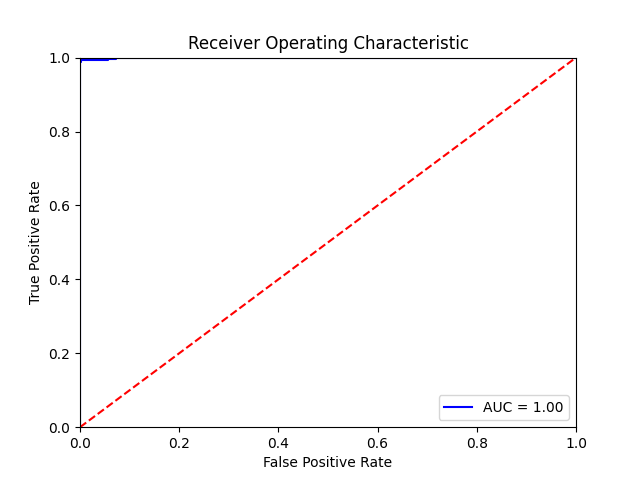

In [30]:
# Plotting ROC Curve
plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

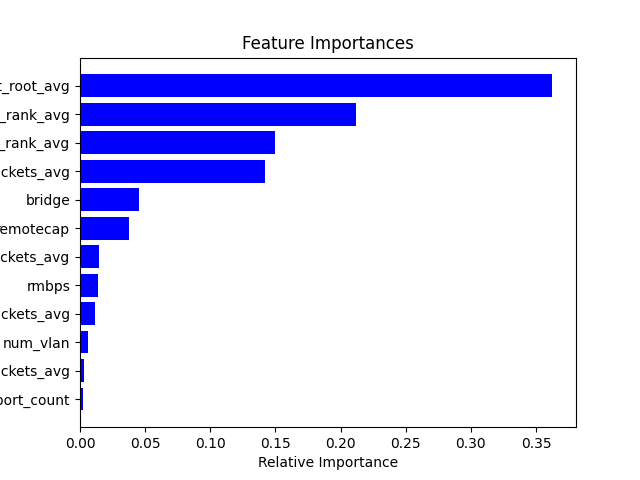

In [31]:
importances = clf.feature_importances_
indices = np.argsort(importances)
feature_cols = Cont_cols+cat_cols_list

plt.clf()
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

%matplot plt

In [32]:
for i in indices[::-1]:
    print(feature_cols[i], " : ", importances[i])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

tx_rx_ucast_root_avg  :  0.3626070507018565
rx_upkt_rank_avg  :  0.2118999421054129
txpkt_rank_avg  :  0.1493042908523533
rx_bcast_packets_avg  :  0.14191218781809925
bridge  :  0.045526450723061884
remotecap  :  0.03751866239081998
rx_packets_avg  :  0.014792188708045386
rmbps  :  0.01357669056248984
tx_bcast_packets_avg  :  0.01157445998545924
num_vlan  :  0.0059236550824025985
tx_ucast_packets_avg  :  0.0027577138509581565
bridge_port_count  :  0.00260670721904079